In [121]:
import pandas as pd
import numpy as np
from pandas import Series
from pandas import ExcelWriter
from pandas import ExcelFile
import seaborn as sns
from pandas.core.nanops import nanmean as pd_nanmean
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
import itertools
from sklearn.metrics import r2_score
from math import factorial

from mypackage import *

from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from bokeh.plotting import figure, output_file, show, ColumnDataSource
matplotlib.style.use('ggplot')

,Value
Date,
1959-01-01,22.8331
1959-02-01,23.2802
1959-03-01,23.6156
1959-04-01,24.1186
1959-05-01,24.4820


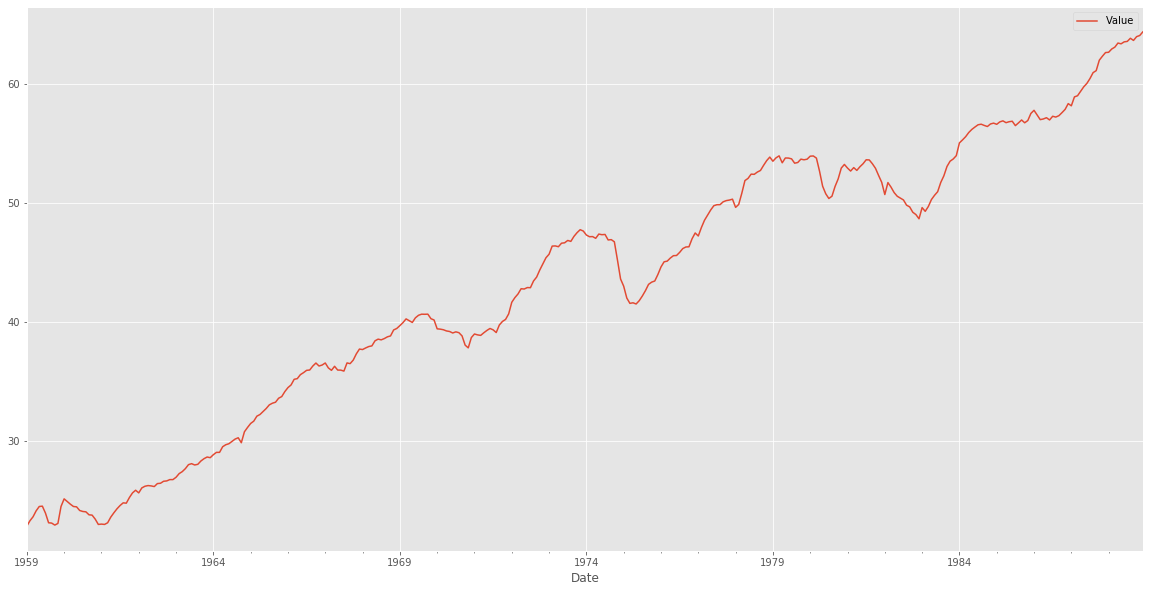

In [78]:
df = pd.read_excel("training.xlsx")
df = df.set_index("Date")
df.plot(figsize=(20,10))
df.head()

In [122]:
def std_dev(x, freq): #среднеквадраичное отклонение
    b = np.asanyarray(x)
    return np.array([(b[i]-np.std(b[i:freq+i])) for i in range(len(x)-freq)])

def series_seasonal(df, window):
    seasonal = np.array([pd_nanmean(df[i::window], axis=0)
                         for i in range(window)])
    return seasonal

def seasonal_mean(x, freq):
    """
    Return means for each period in x. freq is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::freq]) for i in range(freq)])

def series_decompose_sum(df, window):  # Аддитивная модель
    avg = df.Value.rolling(window=30).mean()  # trend, но по-другому
    no_trend = df.Value - avg
    seasonal = series_seasonal(no_trend, 30)
    seasonal = seasonal - np.mean(seasonal, axis=0)
    size = no_trend.shape[0]
    season = np.tile(seasonal.T, size // window + 1).T[:size]  # window = 30
    df['Season1'] = season
    sea_son = df.Season1
    residual = df.Value - avg - season
    return avg, sea_son, residual


def series_decompose_mul(df, window):  # Мультипликативная модель
    avg = df.Value.rolling(window=30).mean()  # trend, но по-другому
    no_trend = df.Value/avg
    seasonal = series_seasonal(no_trend, 30)
    seasonal = seasonal - np.mean(seasonal, axis=0)
    size = no_trend.shape[0]
    season = np.tile(seasonal.T, size // window + 1).T[:size]  # window = 30
    df['Season2'] = season
    sea_son = df.Season2
    residual = df.Value - avg - season
    return avg, sea_son, residual

In [123]:
def plotMovingAverage(series, n):
    from statsmodels.tsa.seasonal import seasonal_decompose
    """
    series - dataframe with timeseries
    n - rolling window size 
    """
    stand_dev = std_dev(series, n).squeeze() #данные исходной серии за вычетом сколзящего среднеквадратичного
    rolling_mean = series.rolling(window=n, center=True).mean() #скользящая средняя
    
    result = seasonal_decompose(series, model='multiplicative', freq=n) #библиотечная функция чтобы сравнить с моим графиком
    
    detrended = series-rolling_mean #убрали тренд
    period_averages = seasonal_mean(detrended, n)#усреднили
    period_averages -= np.mean(period_averages)#??????
    seasonal = np.tile(period_averages, len(series)//n + 1)[:len(series)] #расширили массив, чтобы по размерности совпадал с исходными данными
    detrended= np.asanyarray(detrended).squeeze()
    resid = detrended-seasonal#шум
    
    detrended_multi = series/rolling_mean #дальше все то же самое, но для мультипликативной модели
    period_averages_multi = seasonal_mean(detrended_multi, n)
    period_averages_multi /= np.mean(period_averages_multi)
    seasonal_multi = np.tile(period_averages_multi, len(series) //n + 1)[:len(series)]
    detrended_multi = np.asanyarray(detrended_multi).squeeze()
    resid_multi = detrended_multi/seasonal_multi
    
    #рисуем красиво
    p = figure(
        plot_width = 800,
        plot_height = 600, x_axis_type = 'datetime'
    )  
    
    p.line(
    source = series, x = 'date', y = 'Value', color = 'black', legend = 'Raw Data'
    ) 
    p.line(
    x = series.index, y = seasonal_multi, color = 'cyan', legend = 'Seasonal2'
    )
    p.line(
    x = series.index, y = stand_dev, color = 'purple', legend = 'Std deviation'
    )
    p.line(
    source = rolling_mean, x = 'date', y = 'Value', color = 'magenta', legend = 'Rolling Mean'
    )
    p.line(
    source = result.trend, x = 'date', y = 'Value', color = 'blue', legend = 'Trend'
    )
    p.line(
    source = result.seasonal, x = 'date', y = 'Value', color = 'red', legend = 'Seasonal'
    )
    p.line(
    source = result.resid, x = 'date', y = 'Value', color = 'green', legend = 'Resid'
    ) 
    p.line(
    x = series.index, y = resid_multi, color = 'orange', legend = 'Resid2'
    ) 
    
    show(p)

In [124]:

plotMovingAverage(df,12)


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [125]:
print('ВЫВОД: Временной ряд не является стационарным, так как его математическое ожидание и дисперсия зависят от времени')

ВЫВОД: Временной ряд не является стационарным, так как его математическое ожидание и дисперсия зависят от времени


In [126]:
print('Разложение временного ряда')

Разложение временного ряда


In [127]:
print("1. Аддитивная модель")

1. Аддитивная модель


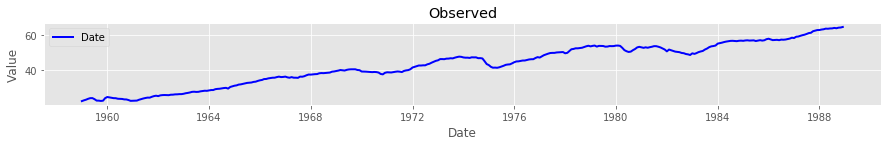

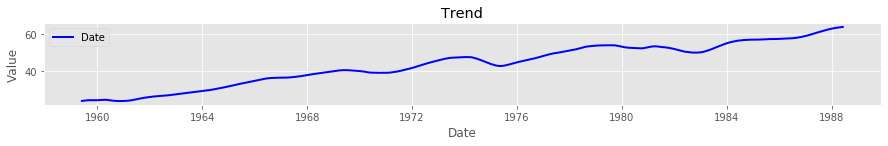

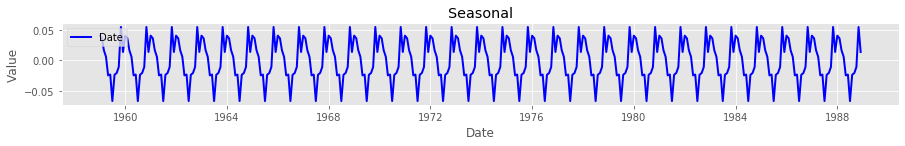

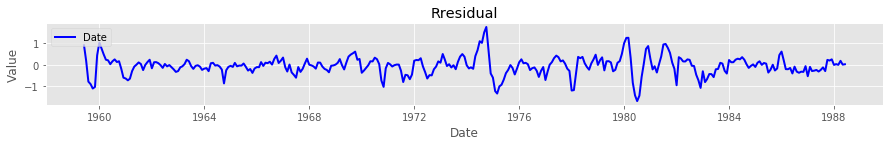

In [128]:
obs, tren, seas, resid = seasonal_decompose(df)
plot_series(obs, x=15, y=1.5, title='Observed')
plot_series(tren, x=15, y=1.5, title='Trend')
plot_series(seas, x=15, y=1.5, title='Seasonal')
plot_series(resid, x=15, y=1.5, title='Rresidual')

In [129]:
print('2. Мультипликативная модель')

2. Мультипликативная модель


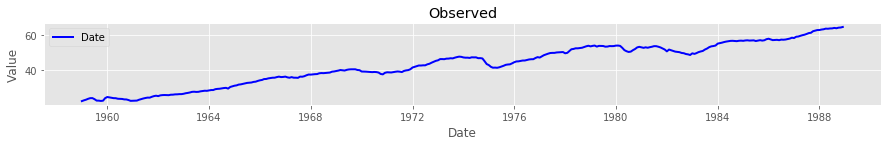

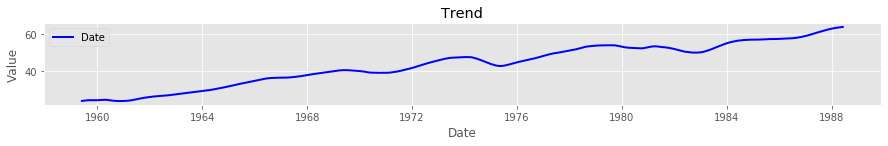

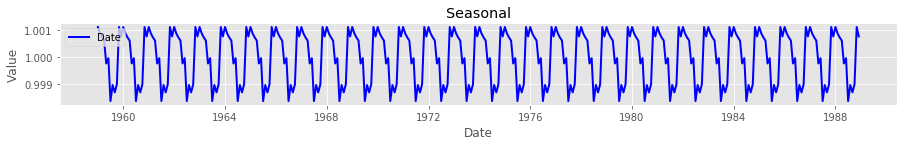

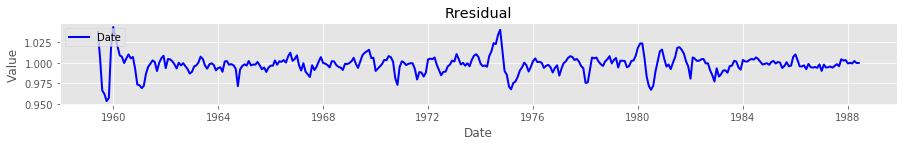

In [130]:
obs, tren, seas, resid = seasonal_decompose(df, model='multiplicative')
plot_series(obs, x=15, y=1.5, title='Observed')
plot_series(tren, x=15, y=1.5, title='Trend')
plot_series(seas, x=15, y=1.5, title='Seasonal')
plot_series(resid, x=15, y=1.5, title='Rresidual')

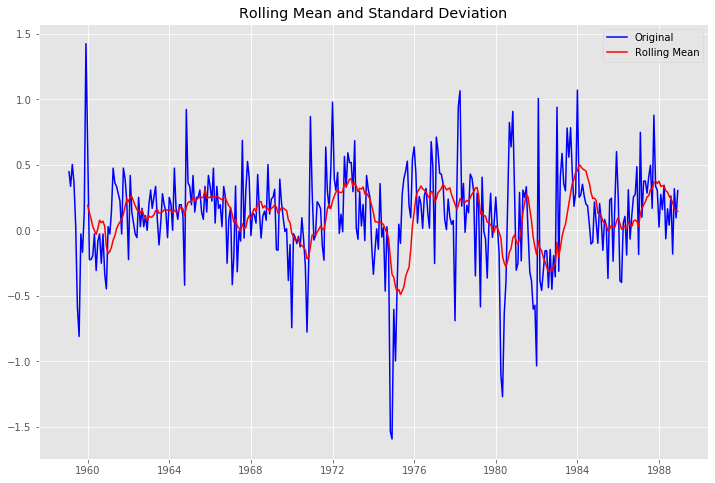

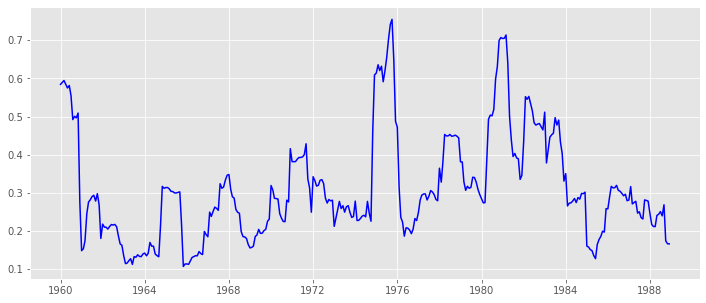

Итак, мы получили, что первые разности ряда стационарны, значит он является интегрируемым рядом первого порядка. Определен параметр для ARIMA(p,d,q) : d = 1


In [131]:
#Выясним порядок интегрированности нашего ряда, начнем с дифференцирования первого порядка.
rcParams['figure.figsize'] = 12, 5
sample = df.Value - df.Value.shift(1)
sample.dropna(inplace=True)
# test_stationarity(sample_data_diff, window = 48)
# Determing rolling statistics
timeseries = sample
rolmean = timeseries.rolling(12).mean()
rolstd = timeseries.rolling(12).std()

# Plot rolling statistics:
fig = plt.figure(figsize=(12, 8))
orig = plt.plot(timeseries, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation')
plt.show()
std = plt.plot(rolstd, color='blue', label='Rolling Std')

plt.show()
print('Итак, мы получили, что первые разности ряда стационарны, значит он является интегрируемым рядом первого порядка. Определен параметр для ARIMA(p,d,q) : d = 1')

ARIMA(p,d,q) : q = 3 - номер последнего несезонного лага, при котором автокорреляция значима.
ARIMA(p,d,q) : p = 1 - номер последнего несезонного лага, при котором частичная автокорреляция значима


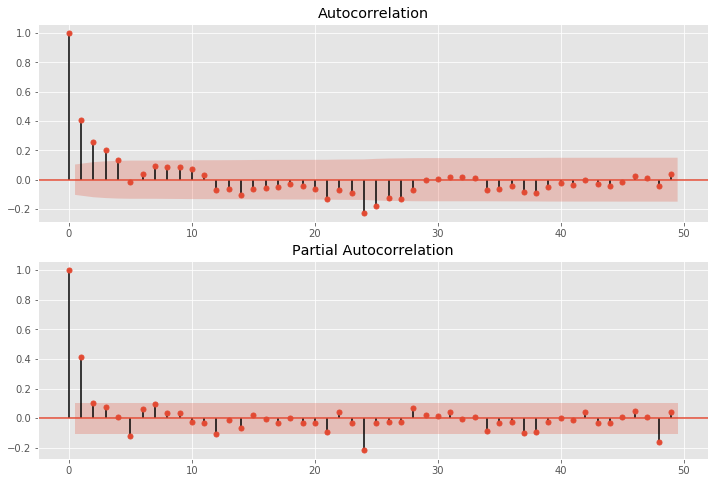

In [132]:
# построим автокорреляцию и частичную автокорреляцию ряда
traindiff = df.Value.diff(periods=1).dropna()
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(traindiff.values.squeeze(), lags=49, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(traindiff, lags=49, ax=ax2)
print('ARIMA(p,d,q) : q = 3 - номер последнего несезонного лага, при котором автокорреляция значима.')
print('ARIMA(p,d,q) : p = 1 - номер последнего несезонного лага, при котором частичная автокорреляция значима')

In [133]:
def arima_call(train, order, test):
    model = sm.tsa.ARIMA(train.Value.squeeze(), order=order, freq='MS').fit()
    y_r = model.predict(start=train.shape[0],
                        end=train.shape[0]+test.shape[0]-1, typ='levels')
    plt.figure(figsize=(15, 8))
    plt.plot(train.Value, label='Train')
    plt.plot(test.Value, label='Test')
    plt.plot(y_r, label='ARIMA')
    plt.legend(loc='best')
    print('Score: {}'.format(r2_score(test.Value, y_r)))
    print('Aiс: {}'.format(model.aic))
    plt.show()
    return model.aic

Score: -3.3206742418867456
Aiс: 251.08321143936564


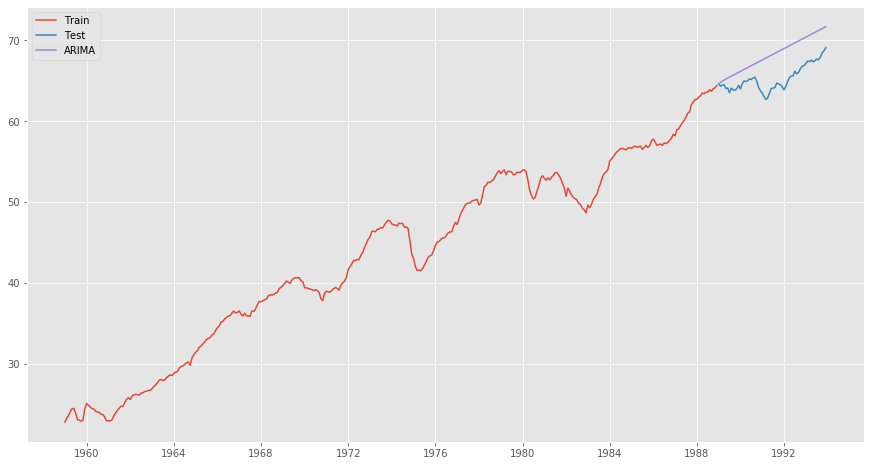

251.08321143936564

In [134]:
dt = pd.read_excel("testing.xlsx")
dt = dt.set_index("Date")
arima_call(df, (1, 1, 3), dt)

Score: -3.281336802817572
Aiс: 248.73365724475104


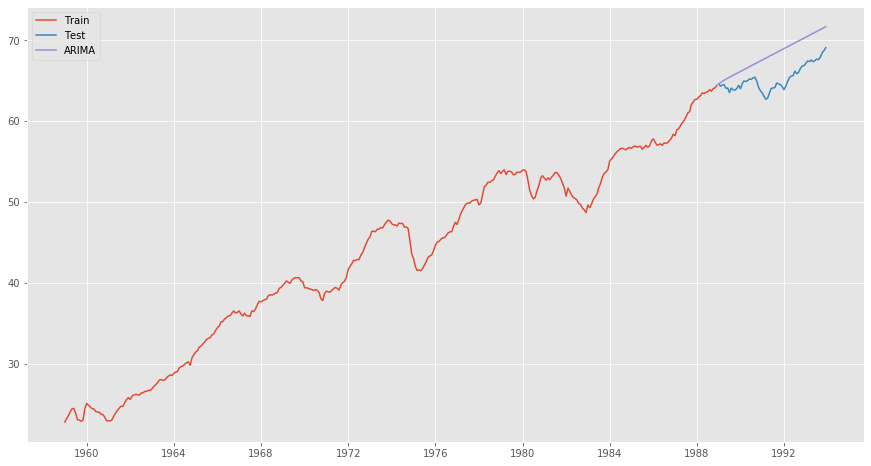

248.73365724475104

In [135]:
# оптимальная по aic с учетом ограничений q + p <= 2
arima_call(df, (1, 1, 1), dt)

In [136]:
print("ACF экспоненциально затухает, начиная с первого лага, причем затухание может носить монотонный или колебательный характер. PACF затухает экспоненциально, монотонно или колебательно.")

ACF экспоненциально затухает, начиная с первого лага, причем затухание может носить монотонный или колебательный характер. PACF затухает экспоненциально, монотонно или колебательно.


Score: -4.019166196992575
Aiс: 241.222488923166


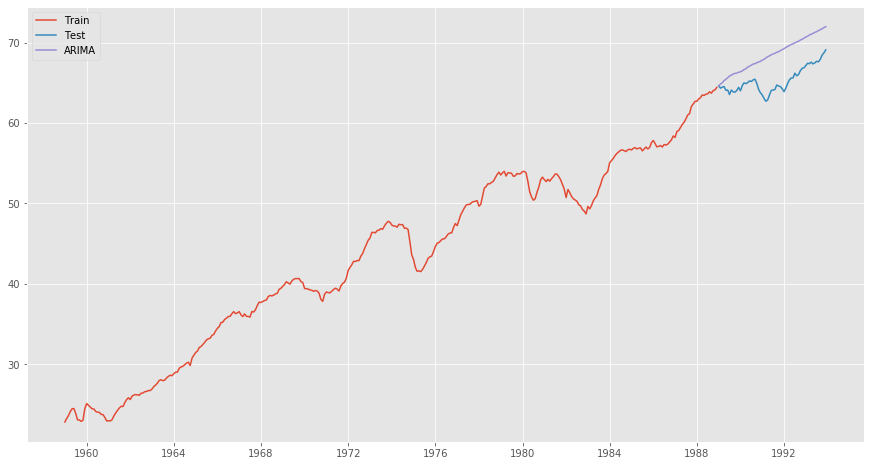

241.222488923166

In [137]:
# оптимальная по aic без ограничений на параметры
arima_call(df, (9, 1, 4), dt)

Score: -2.6828269484402547
Aiс: 315.9856306740645


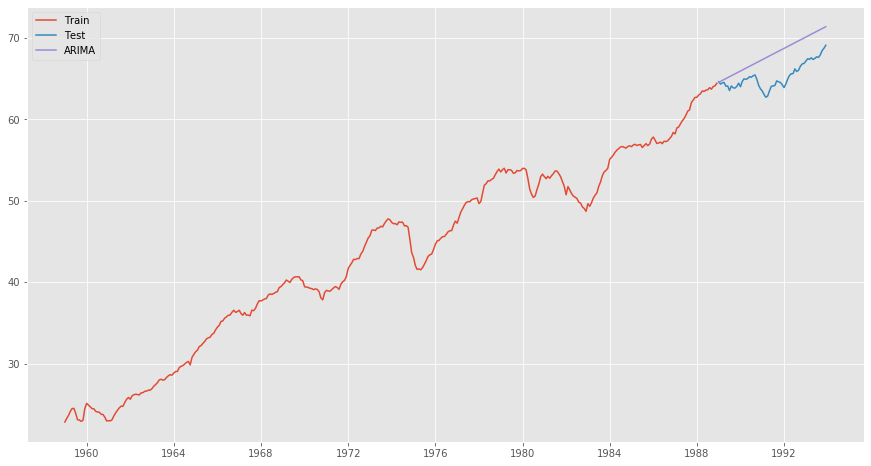

[315.9856306740645, 0, 1, 0]
Score: -2.893071983347613
Aiс: 267.4502825675743


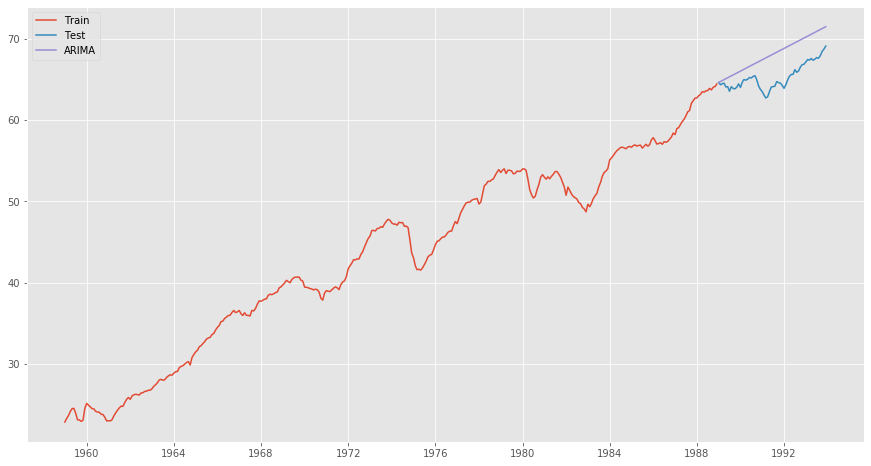

[267.4502825675743, 0, 1, 1]
Score: -2.904659227392406
Aiс: 259.21822259734756


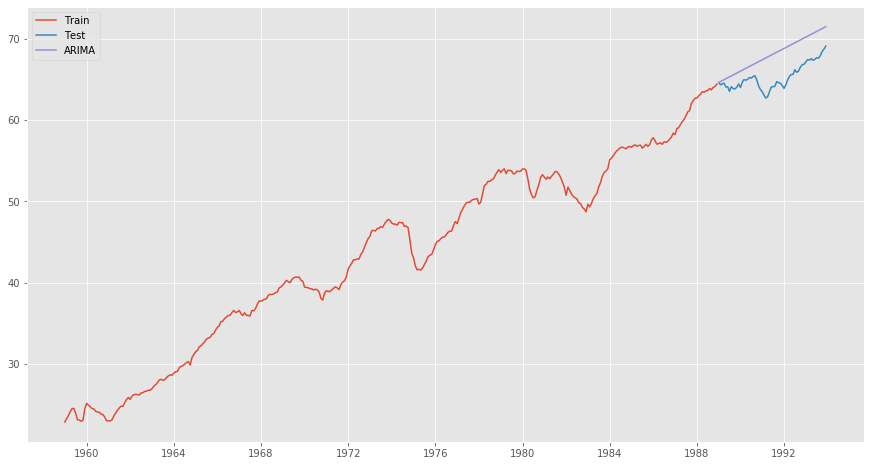

[259.21822259734756, 0, 1, 2]
Score: -3.129238216613915
Aiс: 254.6524870898735


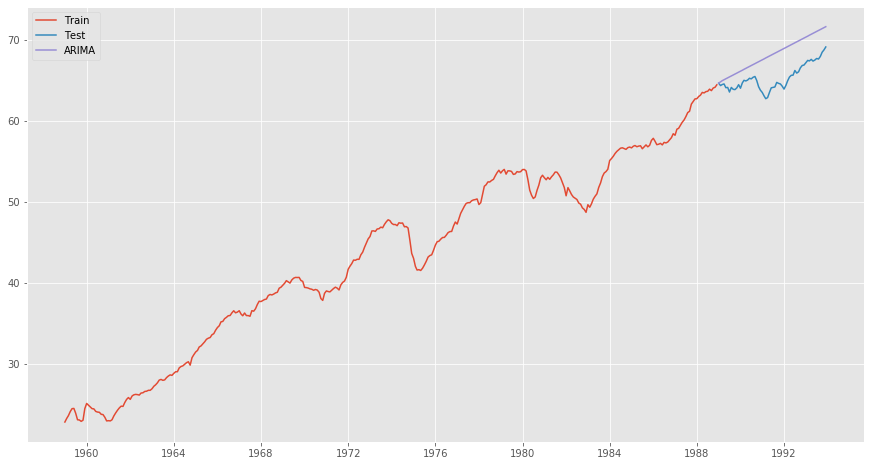

[254.6524870898735, 0, 1, 3]
Score: -3.2275085194506454
Aiс: 245.00535107822452


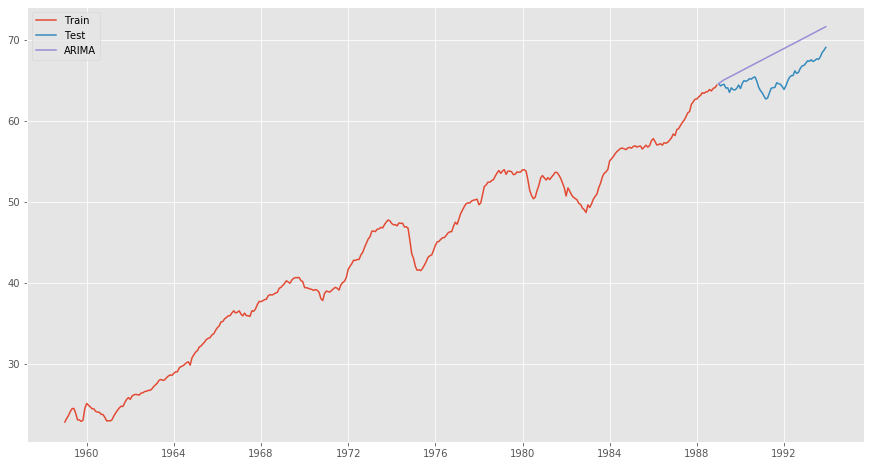

[245.00535107822452, 0, 1, 4]
Score: -3.1581872043682298
Aiс: 246.42770600208348


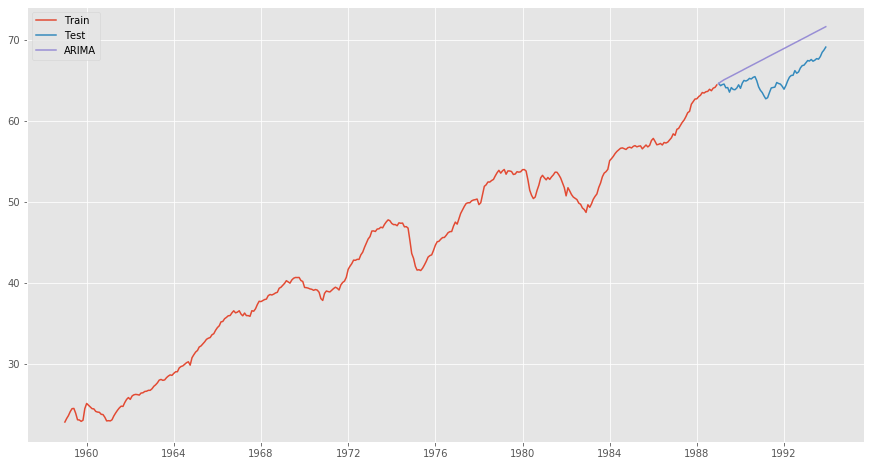

Score: -3.1263060782079943
Aiс: 248.2312668498971


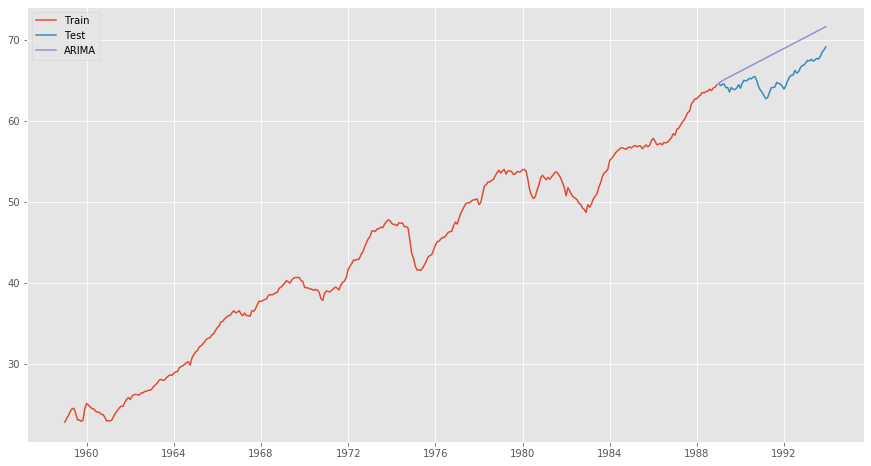

Score: -3.1455205818014393
Aiс: 250.18529975942783


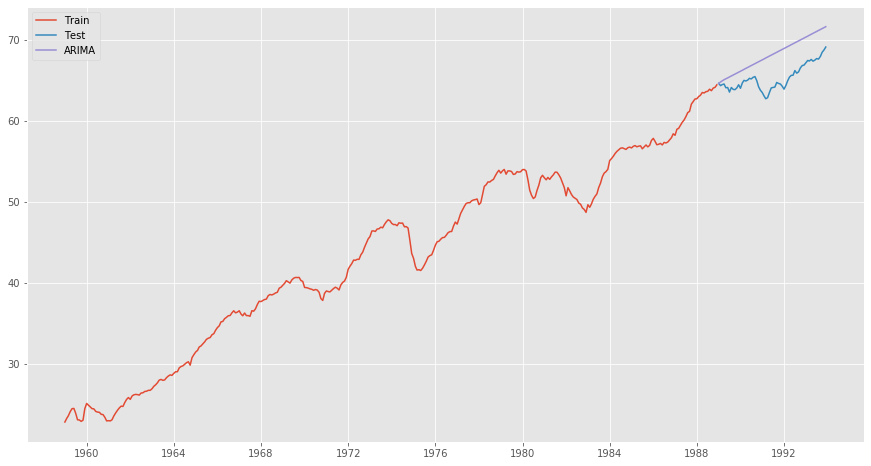

Score: -3.1390276714064473
Aiс: 252.0866250982359


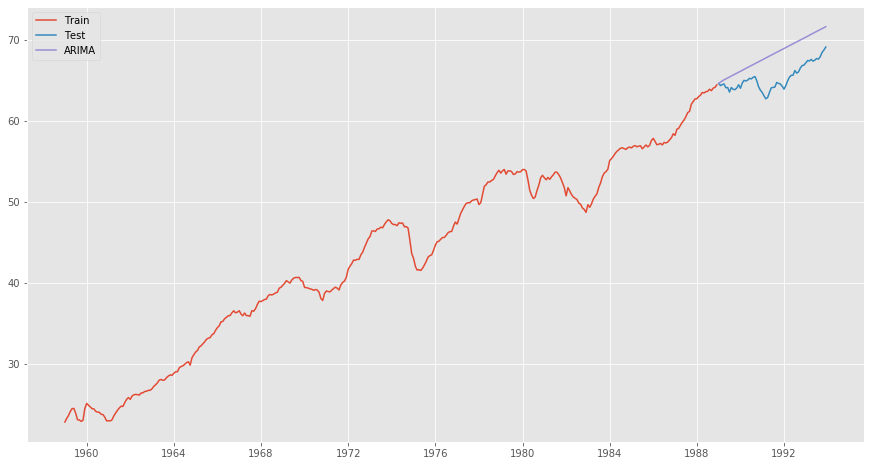

Score: -3.149417513824976
Aiс: 253.86082533166257


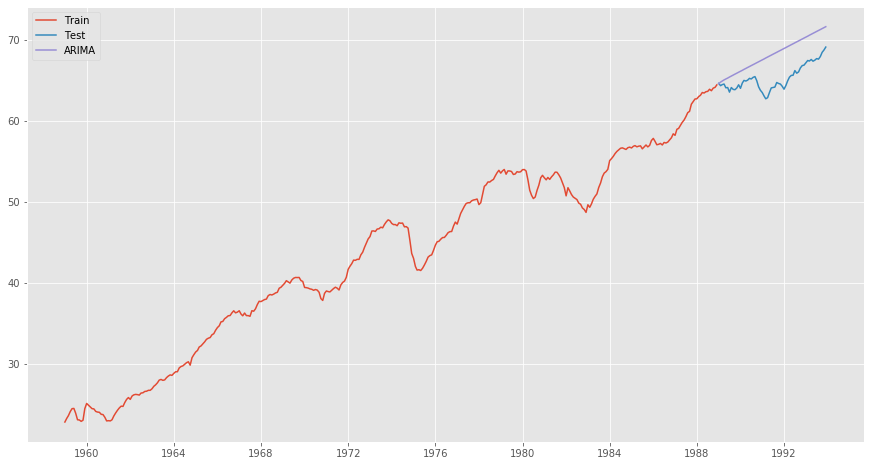

Score: -3.1580143811809256
Aiс: 254.7689096179446


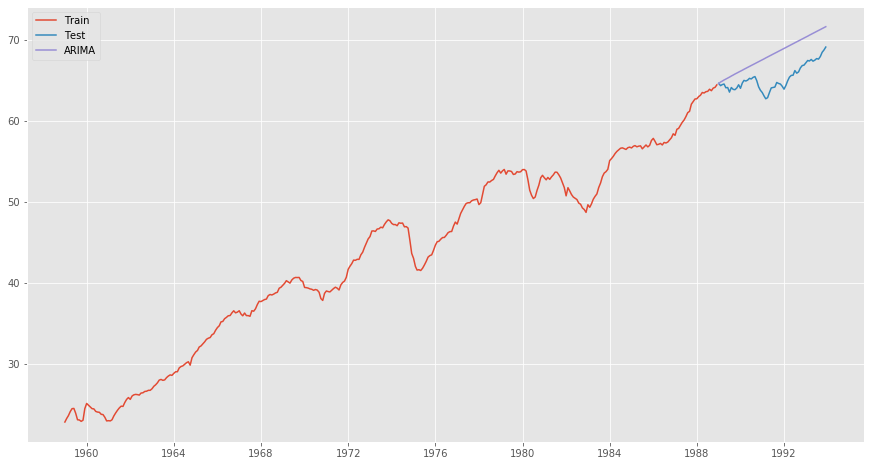

Score: -3.311865612812336
Aiс: 251.5415541722275


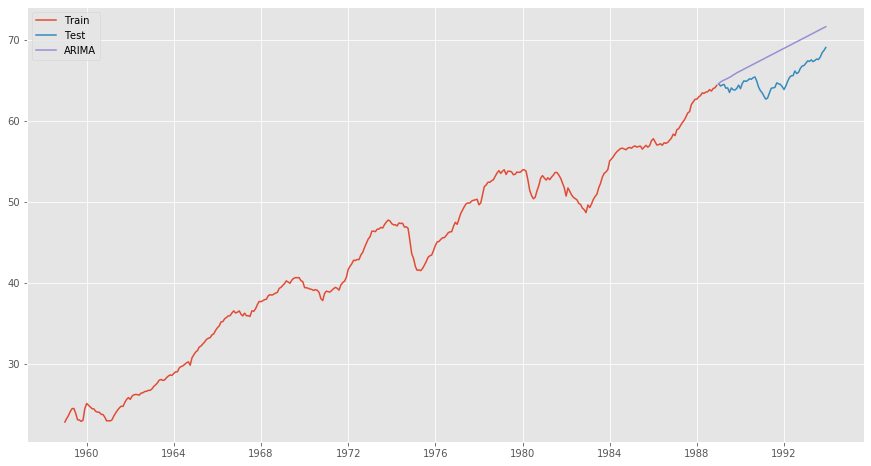

Score: -3.0623208675947566
Aiс: 251.9826620221918


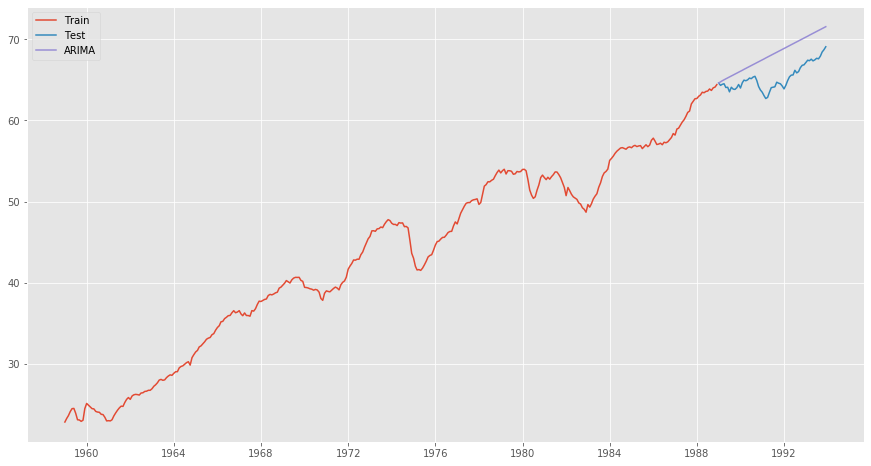

Score: -3.281336802817572
Aiс: 248.73365724475104


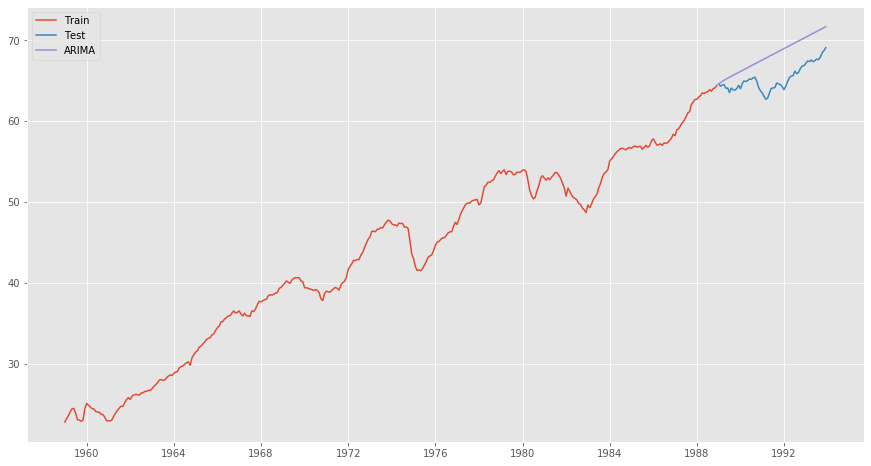

Score: -3.305421464169963
Aiс: 250.6235224042956


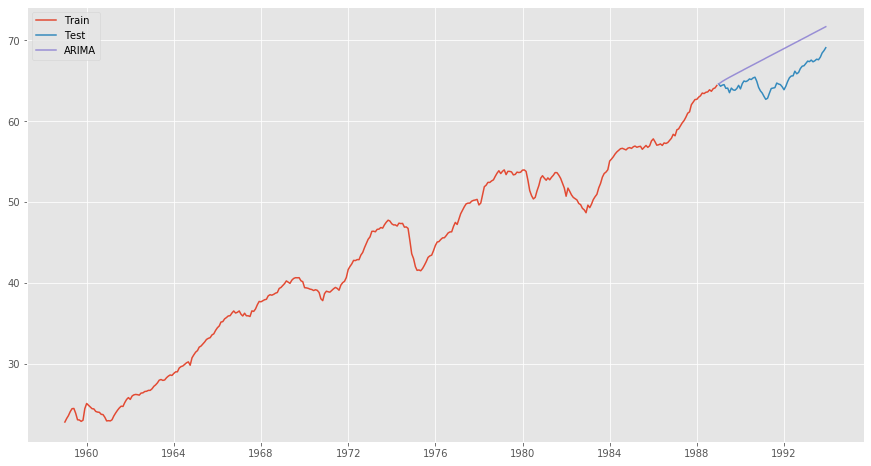

Score: -3.3206742418867456
Aiс: 251.08321143936564


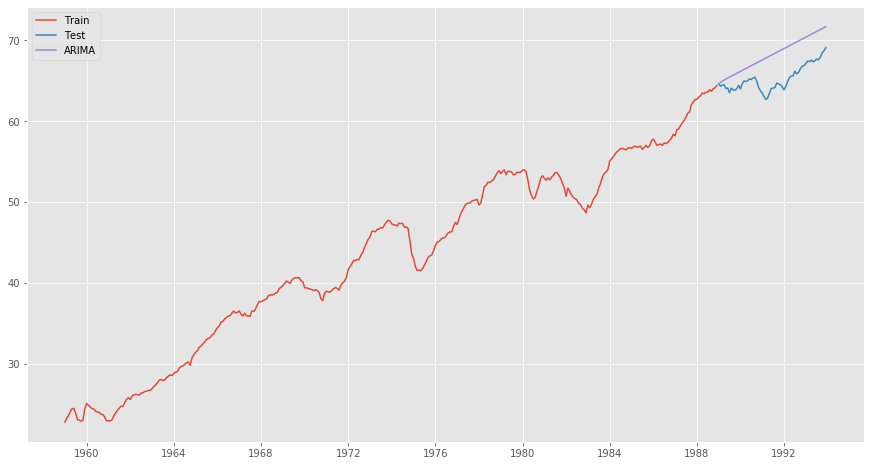

Score: -3.1815372145326712
Aiс: 246.56485731360783


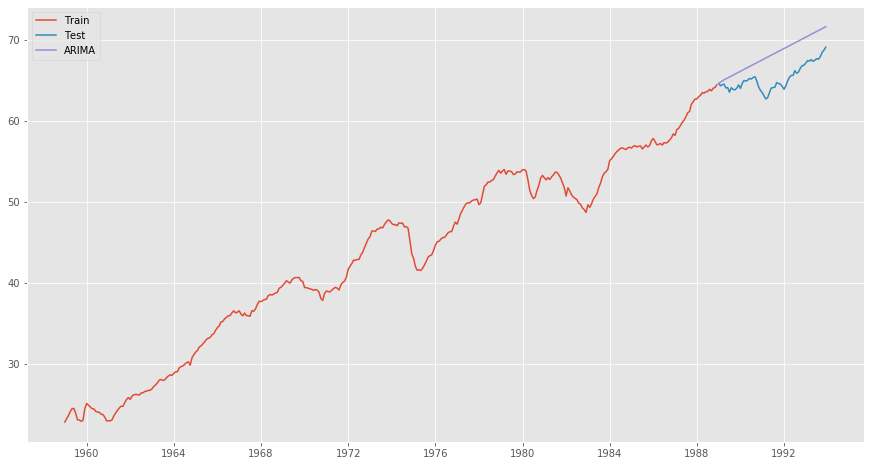

Score: -3.1955950203805203
Aiс: 254.19658243784932


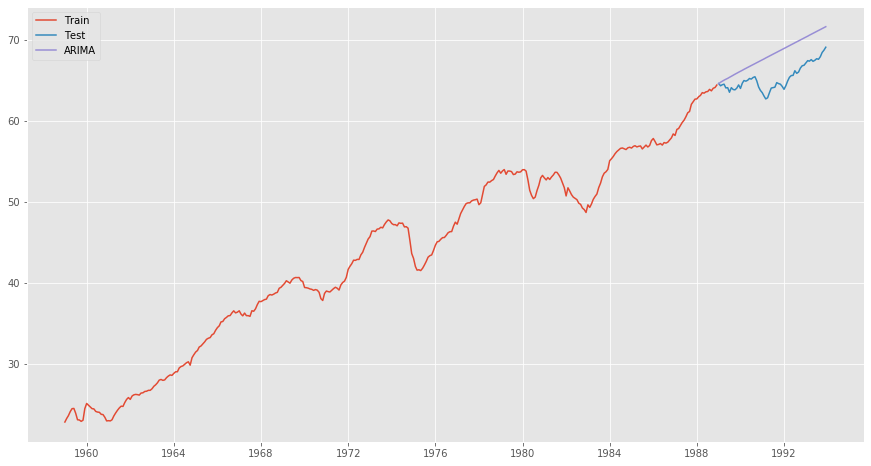

Score: -3.1718219635961216
Aiс: 249.9915539324752


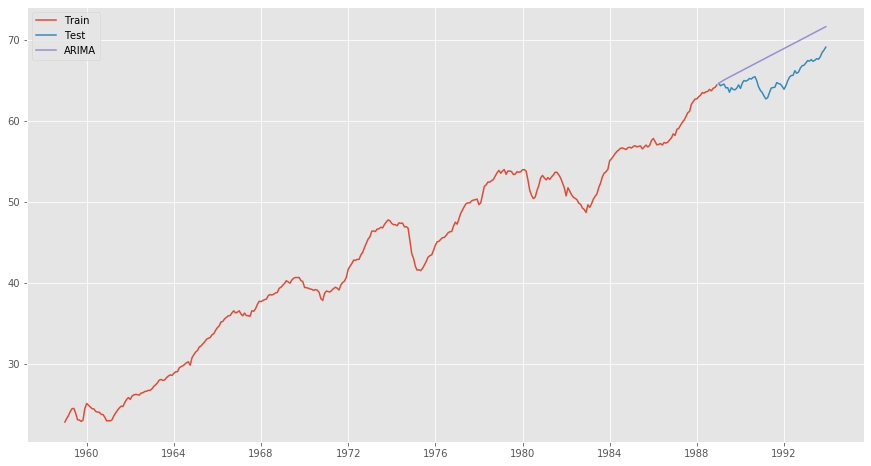

Score: -3.2975649793112085
Aiс: 250.66172836075464


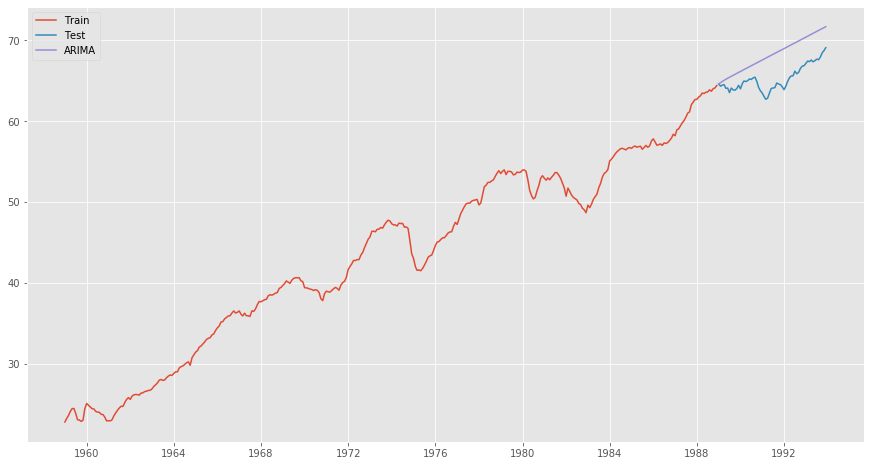

Score: -3.317397655302681
Aiс: 252.50647846456172


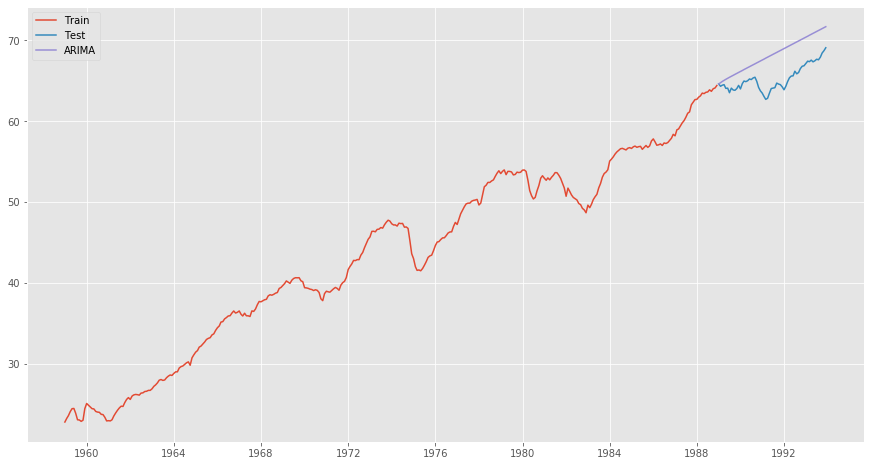

Score: -3.356793637487697
Aiс: 249.86064715939744


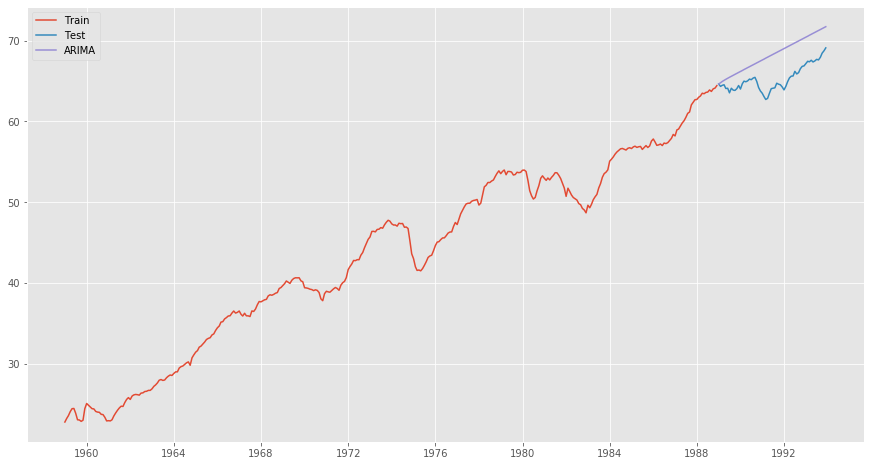

Score: -3.3587099283781523
Aiс: 251.85026704413406


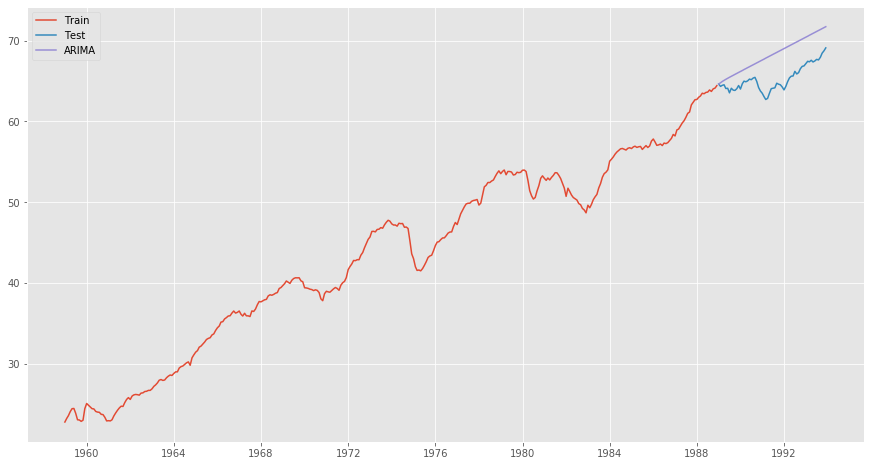

Score: -3.2825989237040005
Aiс: 249.4234539398451


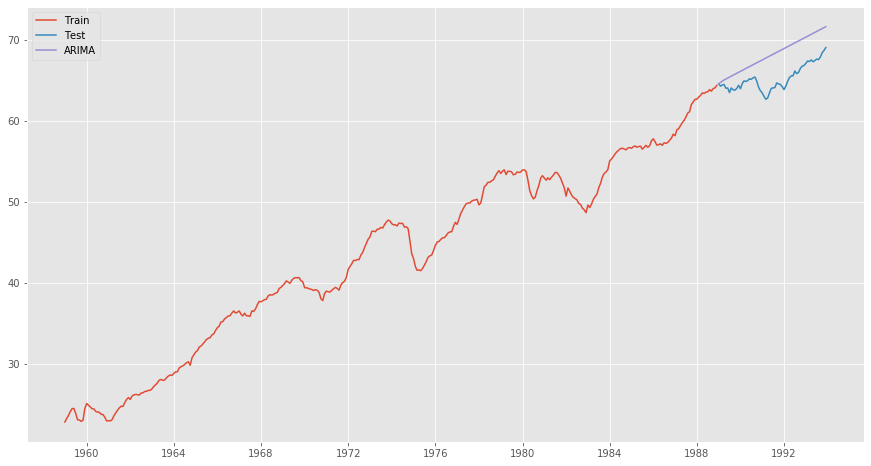

Score: -3.3624937037921176
Aiс: 251.81803529856904


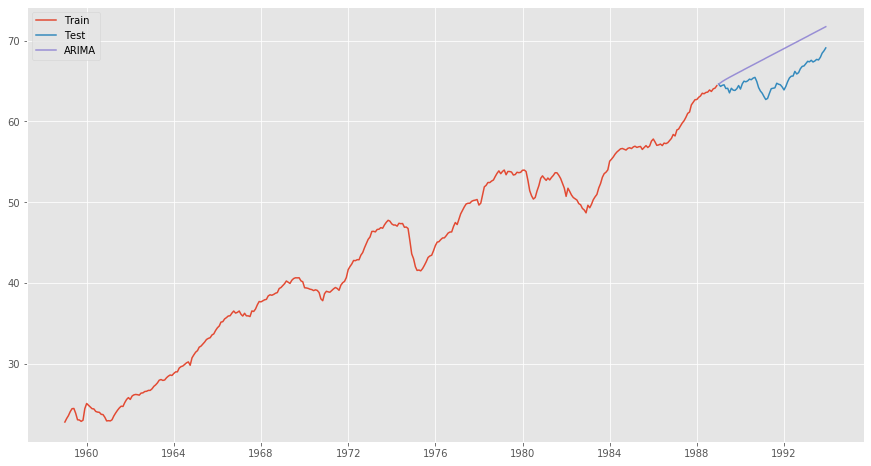

Score: -3.328199200240369
Aiс: 252.1515128213066


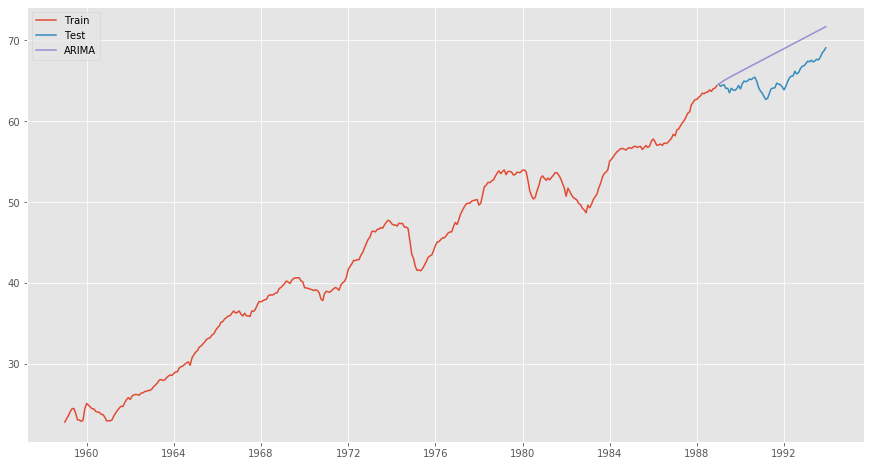

Score: -3.3804600019810263
Aiс: 250.3836987831353


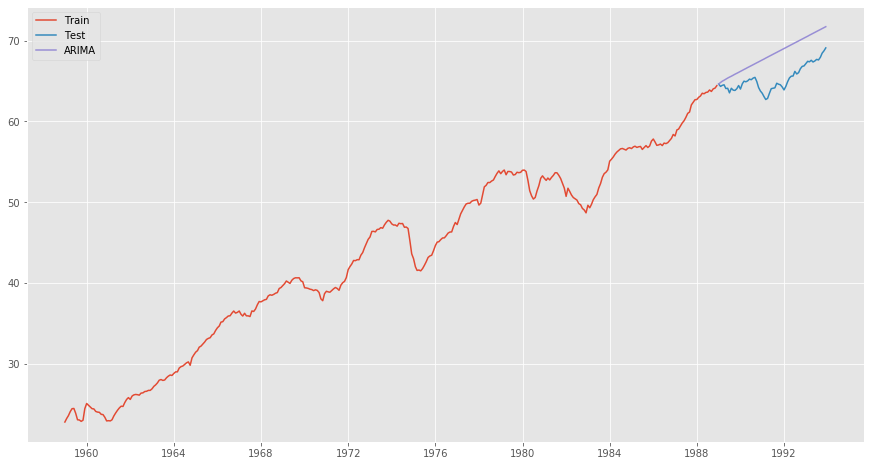

Score: -3.175059260183952
Aiс: 248.47292439923535


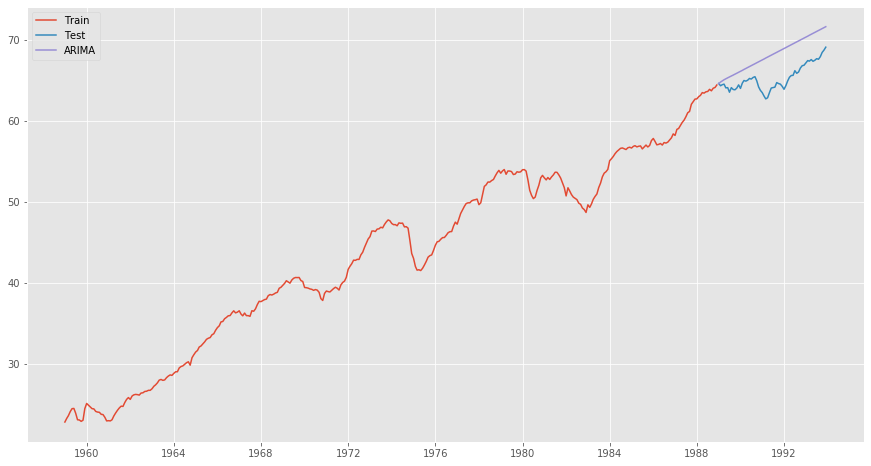

Score: -3.181400139010278
Aiс: 249.94712837370332


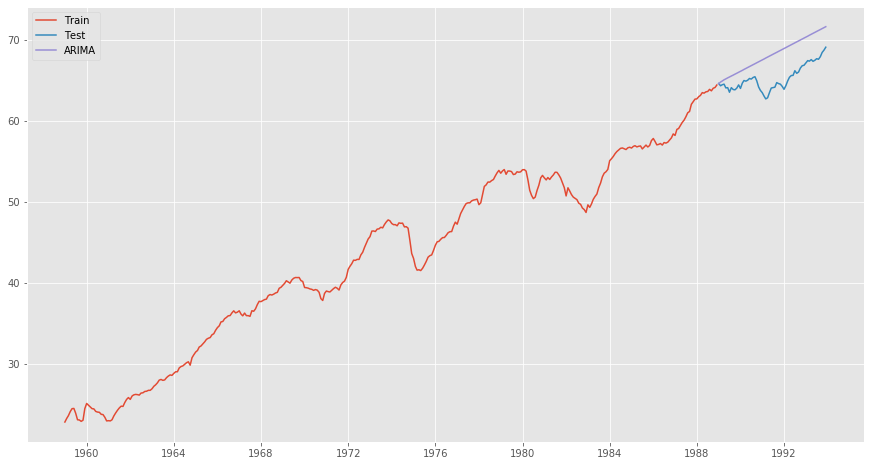

Score: -3.199138547673507
Aiс: 250.62979688366056


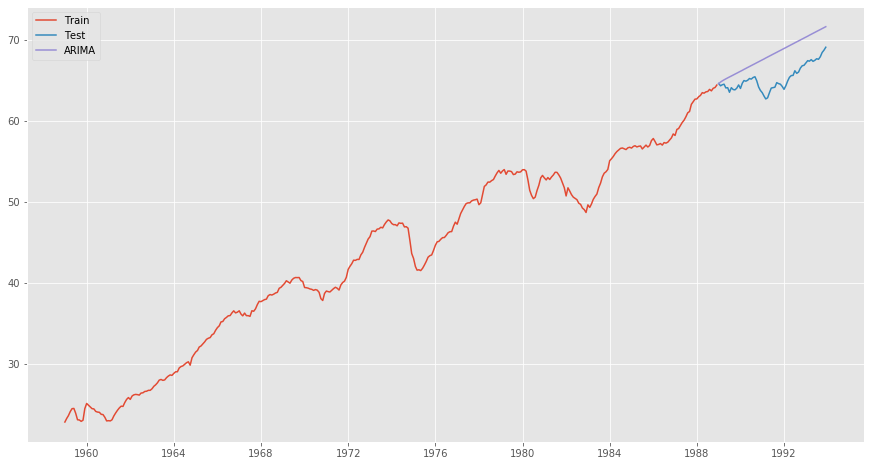

Score: -3.1939839734484083
Aiс: 252.4529609542409


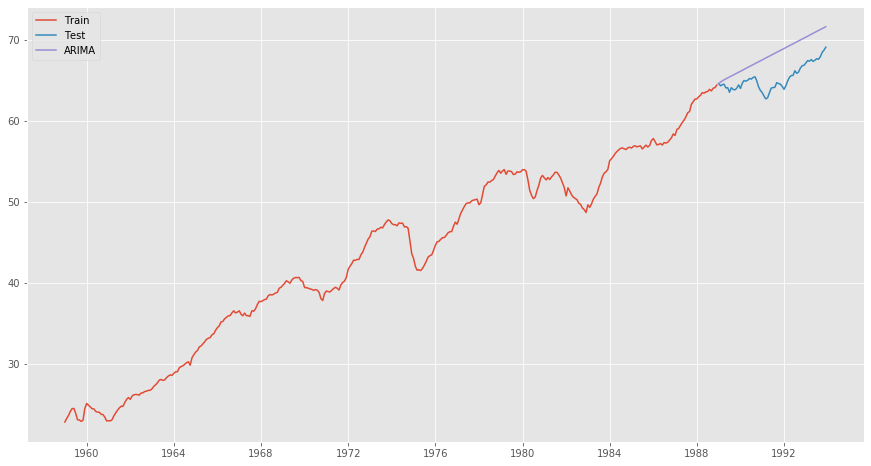

Score: -3.1009232758660845
Aiс: 252.7445169713975


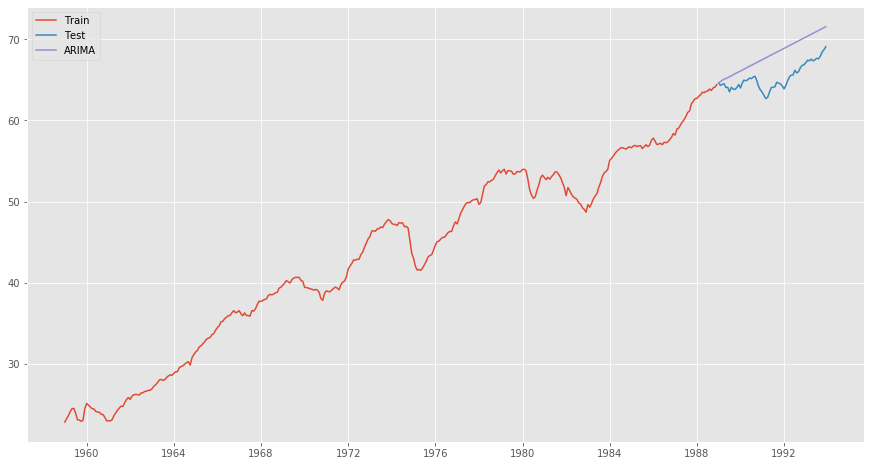

Score: -3.2095997497053785
Aiс: 249.2302354003873


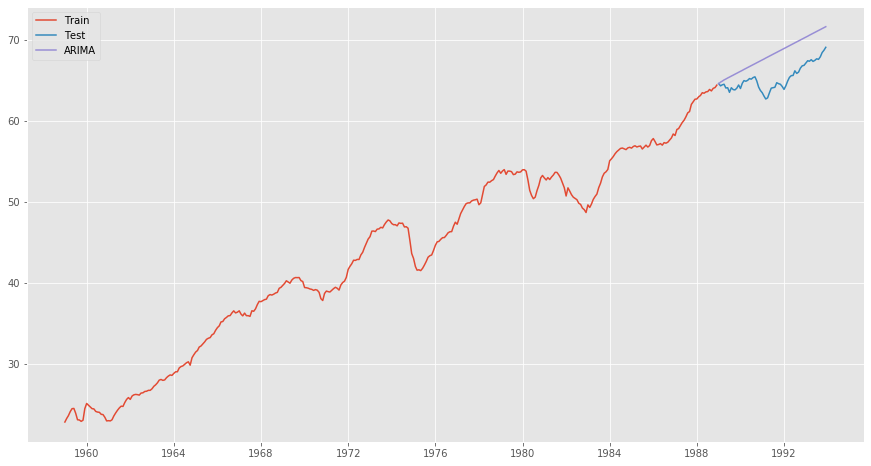

Score: -3.302231888304367
Aiс: 248.99728975963944


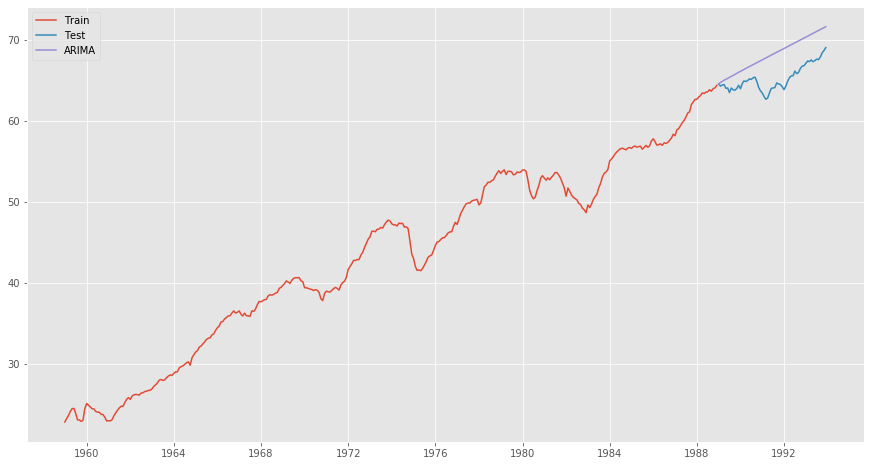

Score: -3.2802813324989035
Aiс: 248.02400759597583


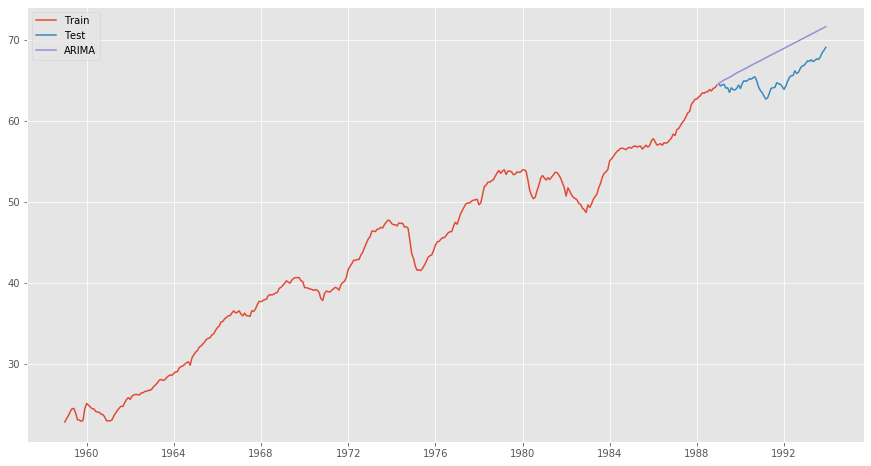

Score: -3.2830324821347556
Aiс: 249.3072392789561


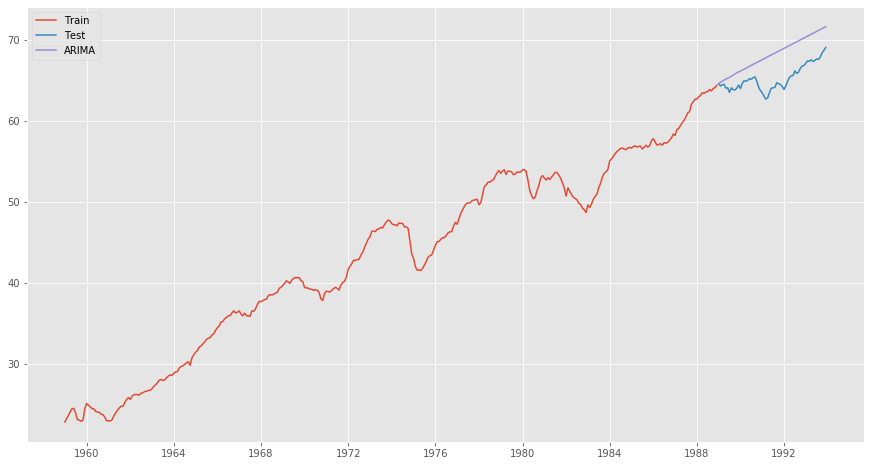

Score: -3.52957556504683
Aiс: 244.18174915605402


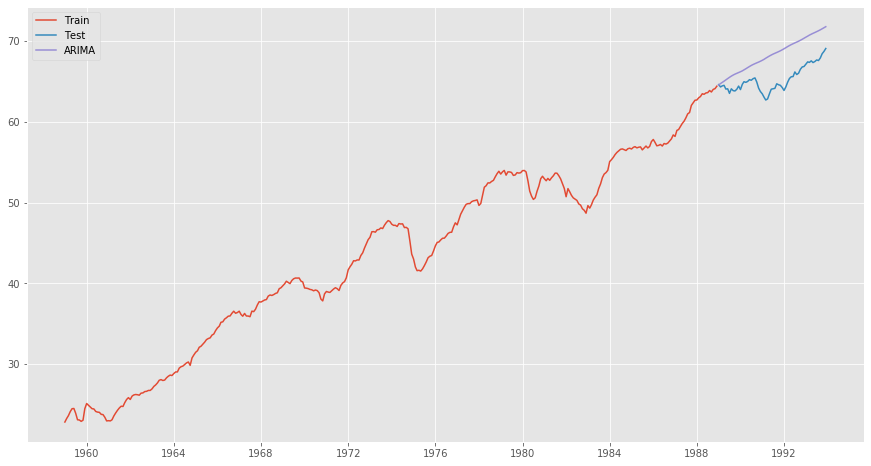

[244.18174915605402, 6, 1, 4]
Score: -3.262356550196192
Aiс: 252.54498342617785


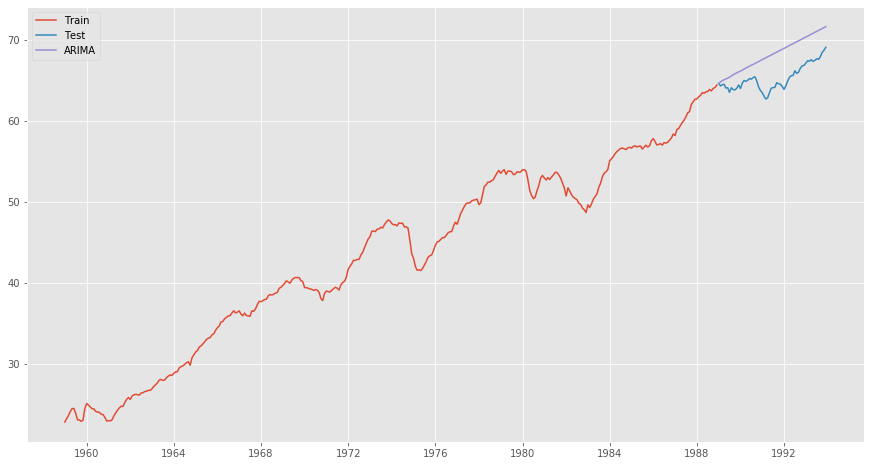

Score: -3.270760695527649
Aiс: 248.43708572174523


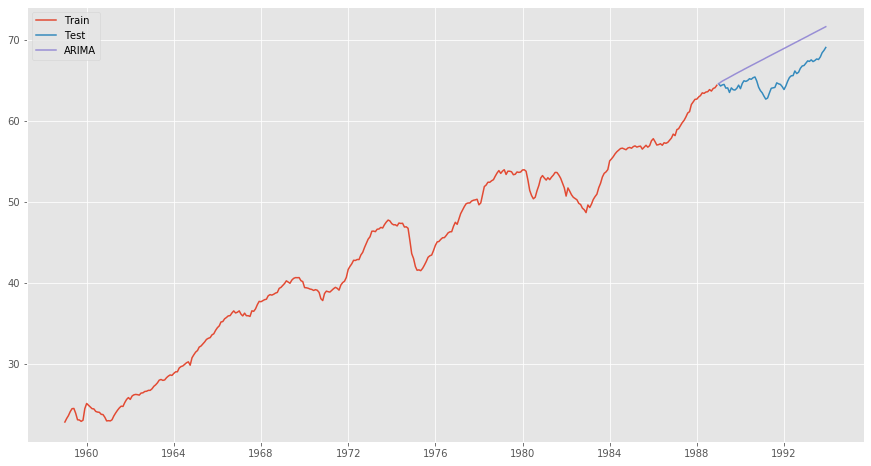

Score: -3.292155605969808
Aiс: 249.80030036960704


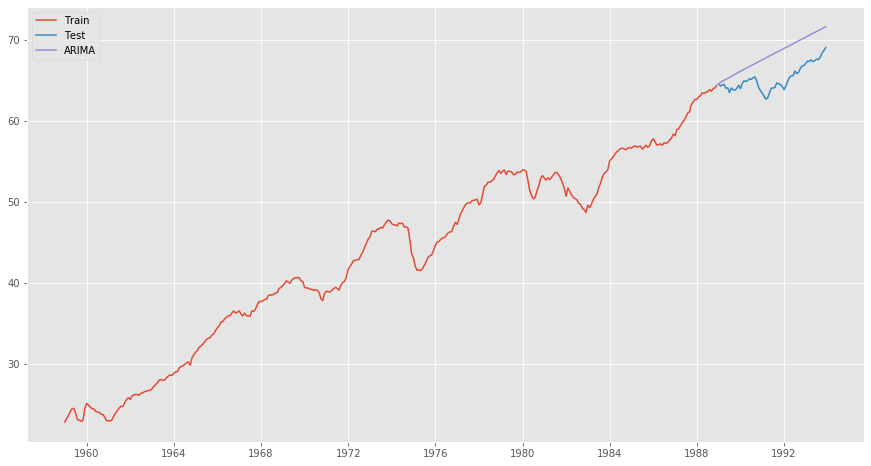

Score: -3.52124016728796
Aiс: 246.34827344969142


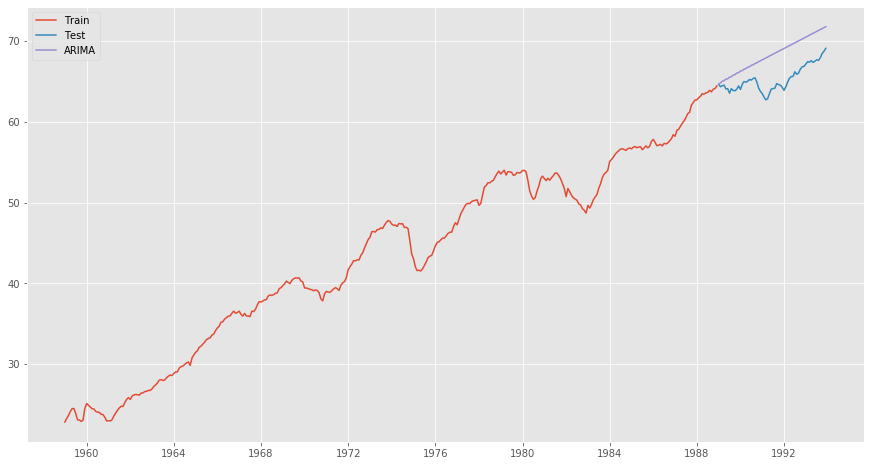

Score: -3.477980963522877
Aiс: 246.8460664149428


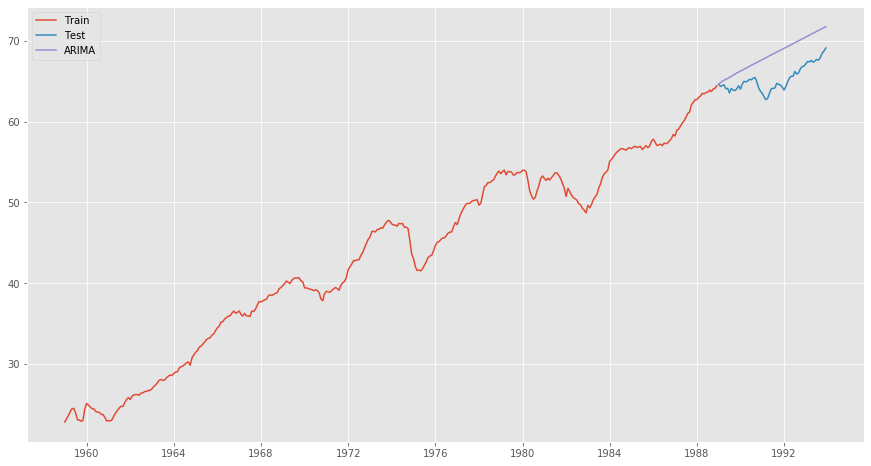

Score: -3.3046004341468675
Aiс: 253.48195025457403


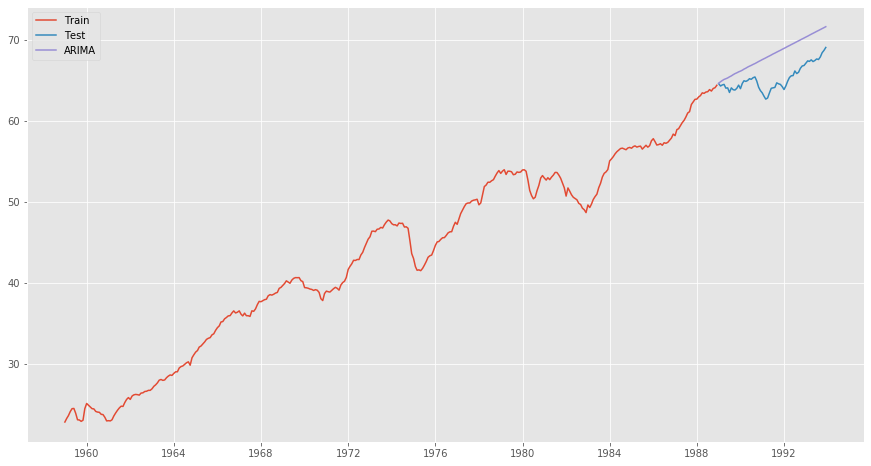

Score: -3.0714157457530336
Aiс: 250.5229322796929


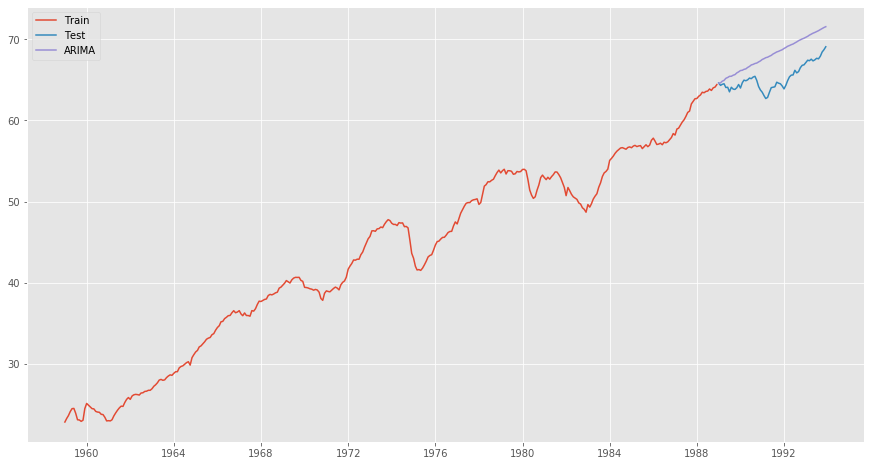

Score: -3.589412595780945
Aiс: 255.7489231589335


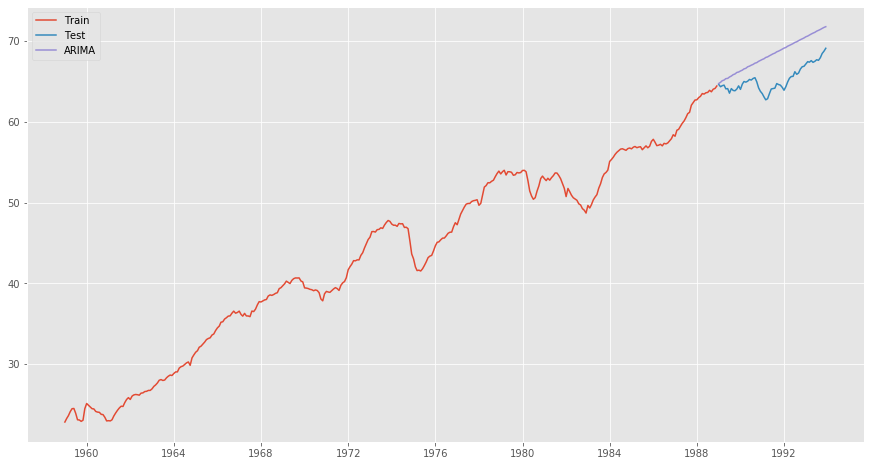

Score: -3.2650886692073096
Aiс: 249.86991639111295


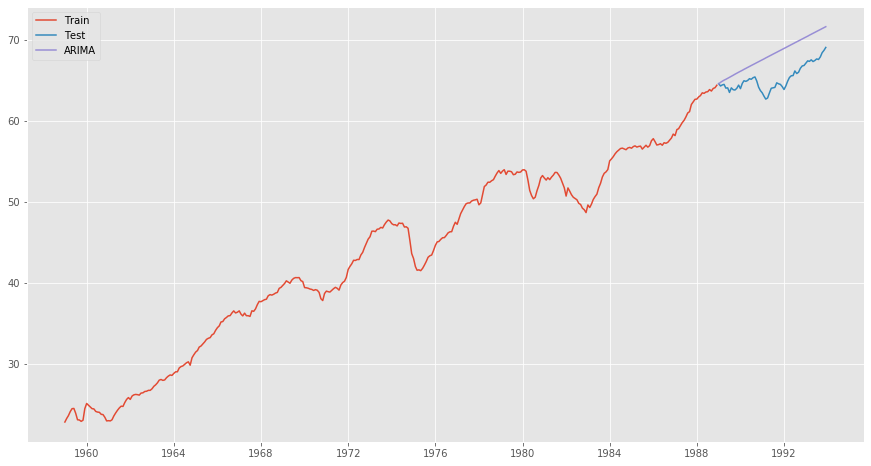

Score: -3.282216513609489
Aiс: 251.71985954151955


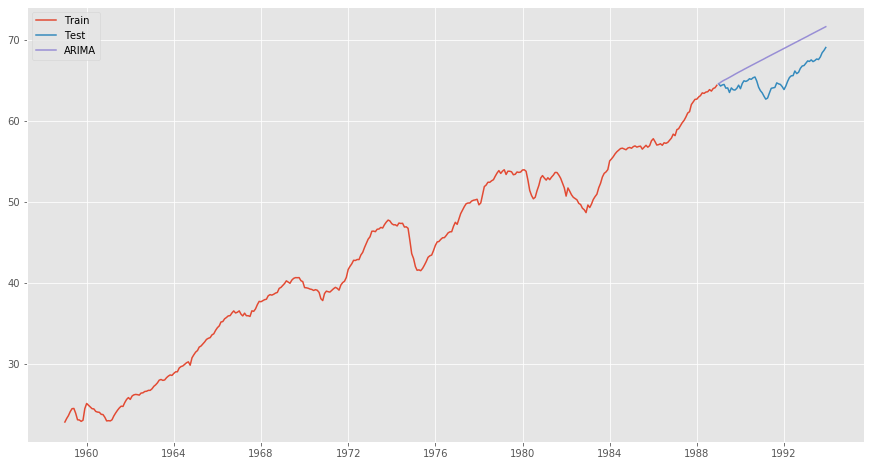

Score: -3.7757528136594845
Aiс: 243.3907058373045


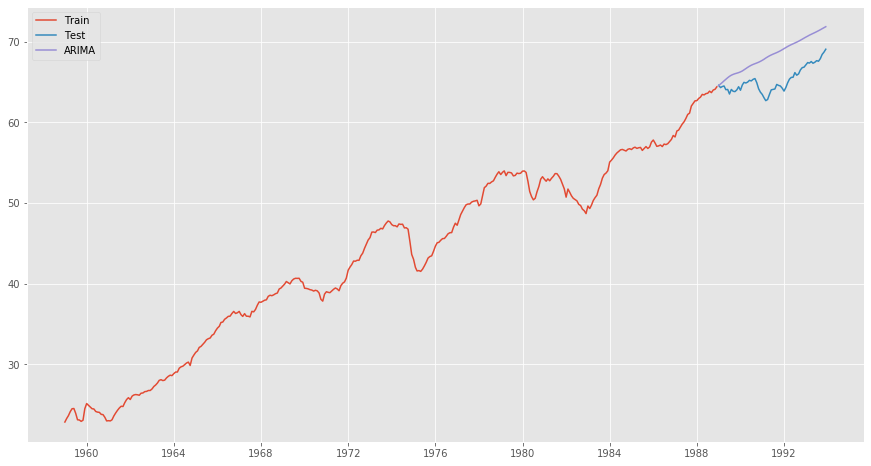

[243.3907058373045, 8, 1, 2]
Score: -3.378733234219504
Aiс: 253.8406239426953


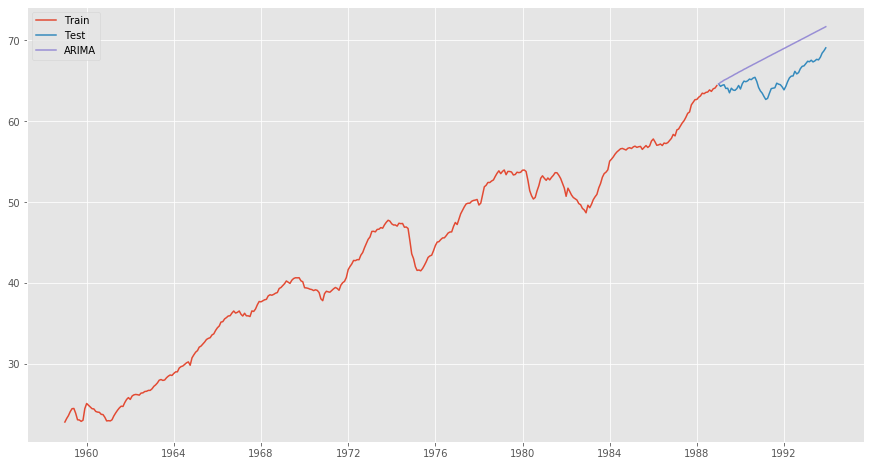

Score: -3.5109686914851626
Aiс: 248.47607864653742


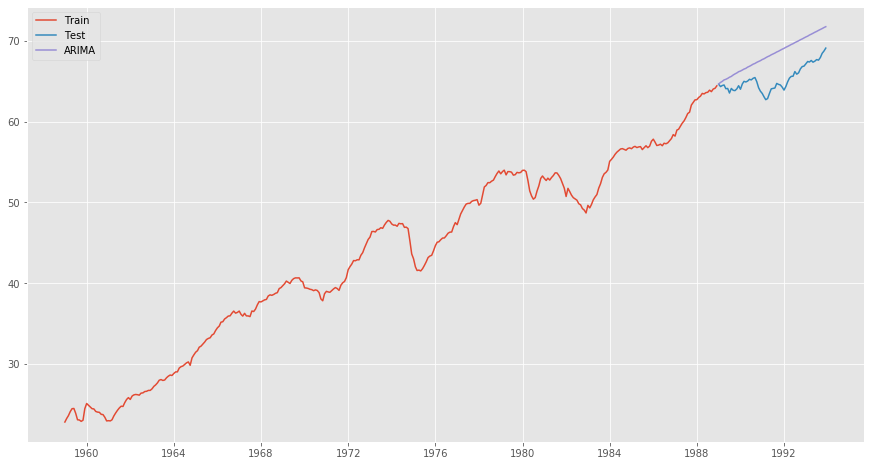

Score: -3.42820660945132
Aiс: 249.62704663615682


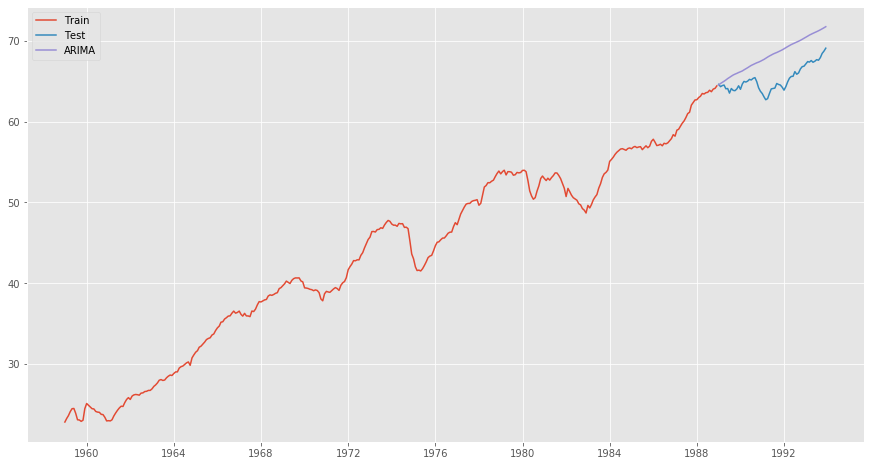

In [ ]:
t = [1000, 0, 1, 0]
p = 0
for a in range(0, 12):
    for b in range(0, 12):
        try:
            d = arima_call(df, (a, 1, b), dt)
        except:
            continue
        if d < t[0]:
            t[0] = d
            t[1] = a
            t[3] = b
            print(t)
print("Final:", t)